### Motivation 
Thermal emission from volcanic eruptions is commonly monitored using infrared sensors (see e.g. the [MODVOLC](http://modis.higp.hawaii.edu/) monitoring archive), since the peak of wavelength-dependent emission intensity falls in the 3-6 $\mu\text{m}$ range for temperatures of fresh lava. 

These sensors are great tools for observing volcanism on Earth, but their use to study volcanism on Venus is **significantly** more challenging. Since Venus' atmosphere is predominantly CO<sub>2</sub> and the surface pressure is almost 100 $\times$ greater than that of Earth, the lower atmosphere is almost entirely infrared-opaque. There are a few narrow infrared windows in the CO<sub>2</sub> spectrum, but these can only be used to observe Venus' surface during its night. Further, the planet's ubiquitous H<sub>2</sub>SO<sub>4</sub> cloud cover can obfuscate the origin of the observed emission. 

<figure class="image">
  <img src="notebooks/smap_volcanism/venus_corona.jpg" alt="Text" width=50%>
  <figcaption>Artist rendering of Venus' surface (Credits: NASA/JPL-Caltech/Peter Rubin)</figcaption>
</figure>


Due to the reduced sensitivity to cloud thermal and backscattered solar emission, passive microwave observations could be an attractive alternative to infrared remote sensing for studying Venus volcanism. The main drawbacks to this approach are both the diffraction-limited low spatial resolution of practical spacecraft microwave radiometer systems and the decrease in emission power density with increasing wavelength. With these downsides, **would the intensity of volcanic surface emission on Venus be strong enough to be observed with a microwave radiometer?** Some have argued that the answer is ['Yes'](https://doi.org/10.1029/2010GL045233) using microwave observations from the Magellan spacecraft. The upcoming ESA EnVision mission to Venus will fly with a similar instrument, providing an opportunity to search for volcanic thermal emission anomalies and generally how Venus' surface has changed over the past 40-odd years. 


<figure class="image">
  <img src="notebooks/smap_volcanism/EnVision_SMAP.jpeg" alt="Text" width=50%>
  <figcaption>(Left) EnVision (Credits: ESA/NASA/Paris Observatory/VR2Planets) <br> (Right) SMAP (Credits: NASA)</figcaption>
</figure>

Aside from Venus observations, we can test test this question using passive microwave observations of Earth's volcanoes as case studies. The Soil Moisture Active/Passive (SMAP) mission, operating from 2015 to today, includes a microwave radiometer operating at a comparable wavelength and with comparable spatial resolution to the Magellan and EnVision instruments; it is a great analog. Can elevated volcanic thermal emission be observed by SMAP on Earth? A [paper](https://doi.org/10.3390/rs12162544) by researchers at JHU/APL argues that SMAP cannot resolve volcanic emission, but I was interested in taking a look at this dataset for myself.  

### Effusive eruptions 

I checked 4 different effusive eruptions which occurred during SMAP's lifetime. I'm looking at this type of eruption specifically because effusive volcanism is expected to be prevalent on Venus 

- Kilauea Lower East Rift Zone, Hawaii, 2018 ([shapefile source](https://www.sciencebase.gov/catalog/item/5eba3f6082ce25b5135d5b85))
- Mt. Nyiragongo, DRC, 2021 ([shapefile source](https://emergency.copernicus.eu/mapping/list-of-components/EMSR513))
- Cumbre Vieja, Canary Islands, 2021 ([shapefile source](https://emergency.copernicus.eu/mapping/list-of-components/EMSR546))
- Mauna Loa, Hawaii, 2022 ([shapefile source](https://www.google.com/maps/d/viewer?mid=1MYeJDd45rtYgVWJTklrFvFC9Oyq9kJ0&femb=1&ll=19.550210273404762%2C-155.515648&z=13))

*Note: I'm importing files from my local machine, but providing references and maintaining the original file names as downloaded wherever possible!* 

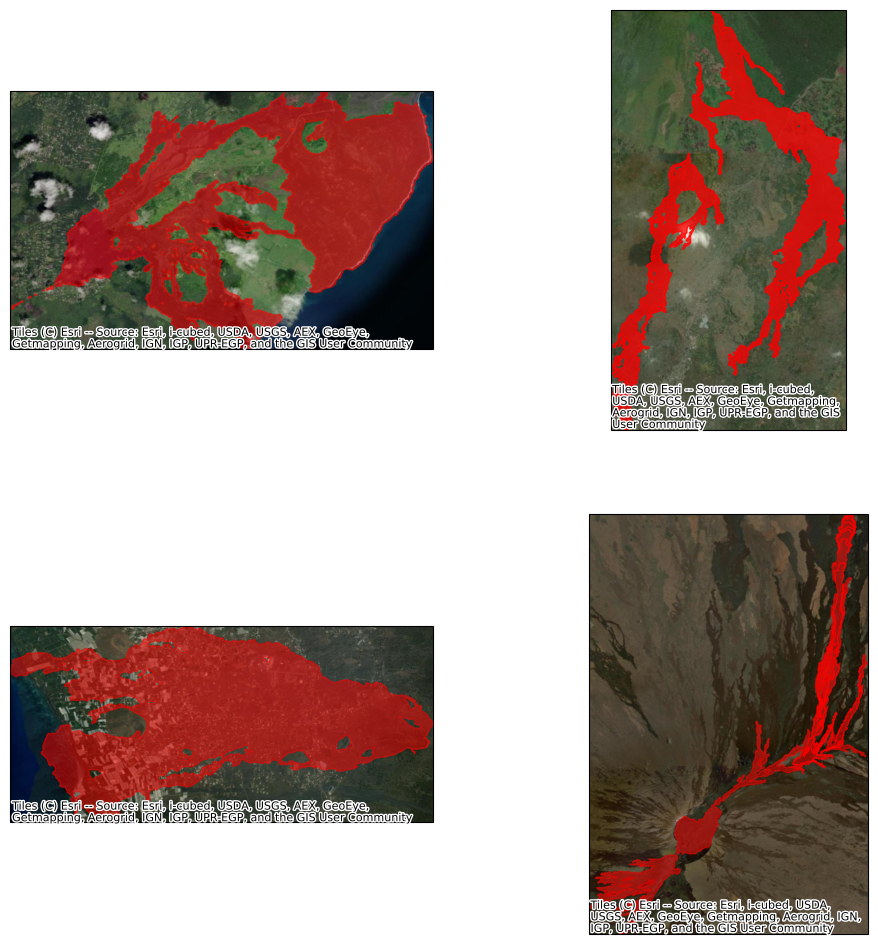

In [1]:
import matplotlib.pyplot as plt 
import cartopy.crs as ccrs
import geopandas as gpd
import fiona # Imported to update settings when called within geopandas 
fiona.drvsupport.supported_drivers['libkml'] = 'rw' # enable KML support which is disabled by default
fiona.drvsupport.supported_drivers['LIBKML'] = 'rw' 
import contextily as cx 


pc = ccrs.PlateCarree() 
fig = plt.figure(figsize=(12,12)) 

def make_plot(frame, ax):
    ax.add_geometries(frame['geometry'], crs=pc, color='r', alpha=0.5)
    ax.set_extent(frame.geometry.total_bounds[[0, 2, 1, 3]], crs=pc)
    cx.add_basemap(ax, crs=pc, source=cx.providers.Esri.WorldImagery) 

# Kilauea 
ax = fig.add_subplot(221, projection=pc)
file = 'shapefiles/Kilauea/KIL_2018_LERZ_Shapefiles/Eruption/KIL_2018_LERZ_FlowFootprint.shp'
kilauea_flow_frame = gpd.read_file(file)
kilauea_flow_frame = kilauea_flow_frame.to_crs(pc.proj4_init)
make_plot(kilauea_flow_frame, ax)

# Nyiragongo 
ax = fig.add_subplot(222, projection=pc)
file = 'shapefiles/Nyiragongo/EMSR513_AOI01_GRA_MONIT02_r1_VECTORS_v3_vector/EMSR513_AOI01_GRA_MONIT02_observedEventA_r1_v3.shp'
nyiragongo_flow_frame = gpd.read_file(file)
nyiragongo_flow_frame = nyiragongo_flow_frame.to_crs(pc.proj4_init)
make_plot(nyiragongo_flow_frame, ax)

# Cumbre Vieja 
ax = fig.add_subplot(223, projection=pc)
file = 'shapefiles/Cumbre Vieja/EMSR546_AOI01_GRA_MONIT63_r1_VECTORS_v1_vector/EMSR546_AOI01_GRA_MONIT63_observedEventA_r1_v1.shp'
cumbrevieja_flow_frame = gpd.read_file(file)
cumbrevieja_flow_frame = cumbrevieja_flow_frame.to_crs(pc.proj4_init)
make_plot(cumbrevieja_flow_frame, ax)

# Mauna Loa
ax = fig.add_subplot(224, projection=pc)
file = 'shapefiles/Mauna Loa/Lava Flow Outline - 2022.kml'
maunaloa_flow_frame = gpd.read_file(file)
maunaloa_flow_frame = maunaloa_flow_frame.to_crs(pc.proj4_init)
make_plot(maunaloa_flow_frame, ax)

### SMAP data

I used the SMAP L1B time-ordered brightness temperature product, which can be [accessed](https://nsidc.org/data/spl1btb/versions/6) at the National Snow and Ice Data Center archive. This product contains both the calibrated brightness temperatures and several other important ancillary parameters. For this analysis, I used observations which span a year before and after the eruption event; these observations can be downloaded using the region selection tools on the NASA EarthData Search [portal](https://search.earthdata.nasa.gov/search). I subsequently read all observation HDF files and combined them by site and year into pandas dataframes (code omitted, an exercise for the reader &#128512;). 

SMAP observation footprints, represented by the antenna half-power beamwidths, are 47- by 39-km ellipses. Shown below are some of the projected observation footprints; the green ellipses show footprints which overlap the flow fields. Two things are immediately apparent by looking at these charts 

1. The flow fields are much smaller than the SMAP footprint resolution 
2. Almost all cases are mixed land/ocean scenes 

To mitigate point 2, I used the land/ocean contamination-corrected brightness temperatures in the L1B files. The difference between nominal land and ocean brightness temperatures at 20 cm wavelength is around 100 K, and ancillary models of land and ocean emission are used to compensate the observed mixed-scene temperature. 

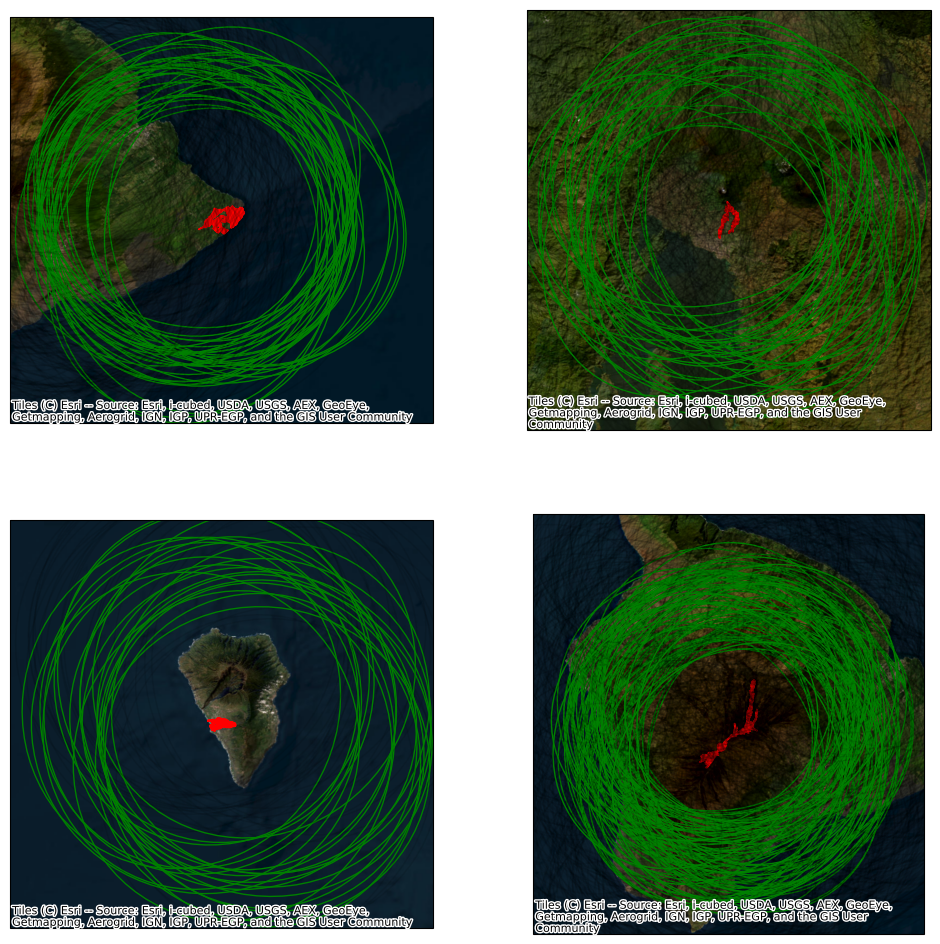

In [2]:
import numpy as np 
import pandas as pd 
from cartopy import geodesic
import cartopy.feature as cfeature
import shapely 
import shapely.geometry as sgeom 
import shapely.affinity as safin


def find_overlap(data_frame, flow_frame):
    # Make footprints as geodesic ellipses using cartopy and shapely 
    geod = geodesic.Geodesic()  # Default is Earth 
    target_coords = np.stack([data_frame['tb_lon'].values, data_frame['tb_lat'].values]).T
    target_circles = [geod.circle(*tc, 39 * 1e3, n_samples=80) for tc in target_coords]
    target_geoms = shapely.polygons(target_circles)
    target_geoms = [safin.scale(tg, xfact=1., yfact=47./39.) for tg in target_geoms]
    target_geoms = [safin.rotate(tg, angle=-data_frame['earth_boresight_azimuth'].values[i]) for i, tg in enumerate(target_geoms)]  
    shapely.prepare(target_geoms)
    data_frame['footprint_geometry'] = target_geoms 

    # Find the overlap between the footprints and the flow fields using geopandas 
    union = flow_frame.unary_union 
    union_centroid = union.centroid 
    union_area = union.area 
    data_frame['center_distance'] = data_frame['footprint_geometry'].apply(lambda x: x.centroid.distance(union_centroid))
    data_frame['overlap_fraction'] = data_frame['footprint_geometry'].apply(lambda x: x.intersection(union).area / union_area)

    return data_frame 

def make_plot(data_frame, flow_frame, ax): 
    ax.add_geometries(flow_frame['geometry'], crs=pc, color='r', alpha=1)
    for i in range(0, len(data_frame), 100): 
        target_feature = cfeature.ShapelyFeature(data_frame['footprint_geometry'].iloc[i], ccrs.Geodetic())
        if data_frame['center_distance'].iloc[i] < 0.15: 
            color='g'
            alpha=1
        else: 
            color='k'
            alpha=0.1
        ax.add_feature(target_feature, facecolor='none', edgecolor=color, alpha=alpha)

    frame_comp = np.array([-0.5, 0.5, -0.5, 0.5])
    ax.set_extent(flow_frame.geometry.total_bounds[[0, 2, 1, 3]] + frame_comp, crs=pc)
    cx.add_basemap(ax, crs=pc, source=cx.providers.Esri.WorldImagery)


fig = plt.figure(figsize=(12,12)) 

# Kilauea 
kilauea_data_frame = pd.concat([pd.read_hdf('data/l1b/kilauea_2017.h5'), pd.read_hdf('data/l1b/kilauea_2018.h5'), pd.read_hdf('data/l1b/kilauea_2019.h5')])
kilauea_data_frame['tb_time_utc'] = pd.to_datetime(kilauea_data_frame['tb_time_utc'].str.decode("utf-8")) # Fix times 
kilauea_data_frame = kilauea_data_frame.sort_values('tb_time_utc')
kilauea_data_frame = find_overlap(kilauea_data_frame, kilauea_flow_frame)
ax = fig.add_subplot(221, projection=pc)
make_plot(kilauea_data_frame, kilauea_flow_frame, ax)

# Nyiragongo
nyiragongo_data_frame = pd.concat([pd.read_hdf('data/l1b/nyiragongo_2020.h5'), pd.read_hdf('data/l1b/nyiragongo_2021.h5'), pd.read_hdf('data/l1b/nyiragongo_2022.h5')])
nyiragongo_data_frame['tb_time_utc'] = pd.to_datetime(nyiragongo_data_frame['tb_time_utc'].str.decode("utf-8")) # Fix times 
nyiragongo_data_frame = nyiragongo_data_frame.sort_values('tb_time_utc')
nyiragongo_data_frame = find_overlap(nyiragongo_data_frame, nyiragongo_flow_frame)
ax = fig.add_subplot(222, projection=pc)
make_plot(nyiragongo_data_frame, nyiragongo_flow_frame, ax)

# Cumbre Vieja
cumbrevieja_data_frame = pd.concat([pd.read_hdf('data/l1b/cumbre_vieja_2020.h5'), pd.read_hdf('data/l1b/cumbre_vieja_2021.h5'), pd.read_hdf('data/l1b/cumbre_vieja_2022.h5')])
cumbrevieja_data_frame['tb_time_utc'] = pd.to_datetime(cumbrevieja_data_frame['tb_time_utc'].str.decode("utf-8")) # Fix times 
cumbrevieja_data_frame = cumbrevieja_data_frame.sort_values('tb_time_utc')
cumbrevieja_data_frame = find_overlap(cumbrevieja_data_frame, cumbrevieja_flow_frame)
ax = fig.add_subplot(223, projection=pc)
make_plot(cumbrevieja_data_frame, cumbrevieja_flow_frame, ax)

# Mauna Loa
maunaloa_data_frame = pd.concat([pd.read_hdf('data/l1b/mauna_loa_2021.h5'), pd.read_hdf('data/l1b/mauna_loa_2022.h5'), pd.read_hdf('data/l1b/mauna_loa_2023.h5')])
maunaloa_data_frame['tb_time_utc'] = pd.to_datetime(maunaloa_data_frame['tb_time_utc'].str.decode("utf-8")) # Fix times 
maunaloa_data_frame = maunaloa_data_frame.sort_values('tb_time_utc')
maunaloa_data_frame = find_overlap(maunaloa_data_frame, maunaloa_flow_frame)
ax = fig.add_subplot(224, projection=pc)
make_plot(maunaloa_data_frame, maunaloa_flow_frame, ax)



### Binning the time-series brightness temperatures 

The first chart below shows the polarization-averaged time-series brightness temperatures for all observations where the Cumbre Vieja flow field is within a footprint. Red bars show the duration of the highest intensity in volcanic activity associated with the event. Due to both receiver noise and differences in viewing geometries, the brightness temperature noise is on the order of 30 K; this can be reduced by binning in time. Subsequent charts show how the choice of time binning interval affects the signal noise. Since I used the SMAP L1B product, I also experimented with binning based on distance of the footprint center from the flow field. In all cases, there is no obvious signal of elevated brightness temperatures associated with volcanism for this region.   

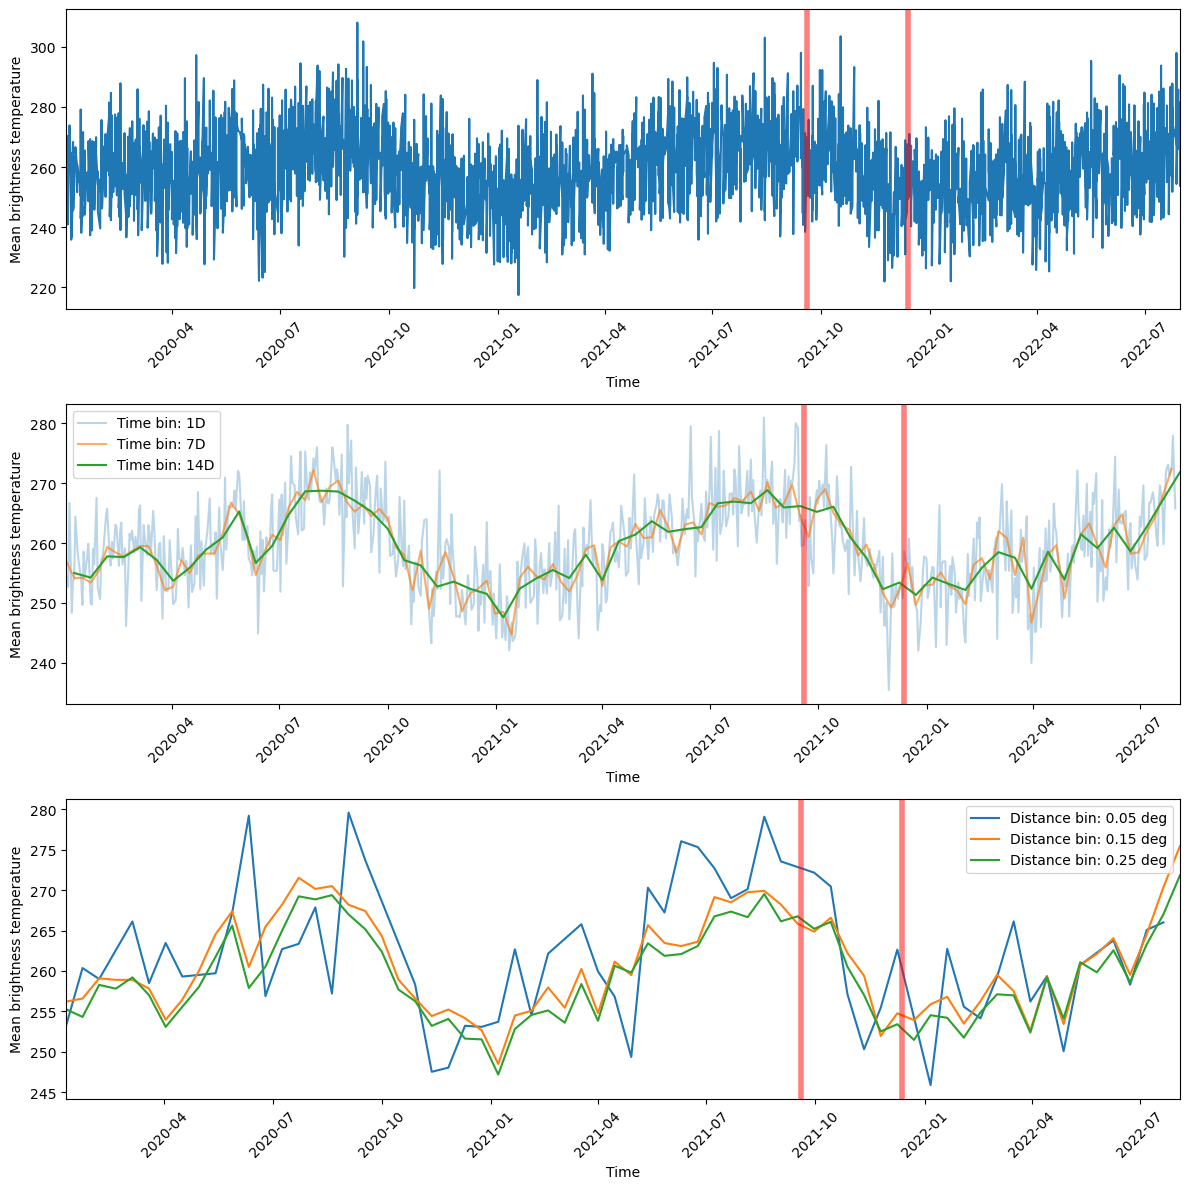

In [7]:
import scipy.stats as stats

def multi_bin_process(frame, ax, time_bins=None, center_bins=None): 
    overlap_mask = ~(frame['overlap_fraction'] < 0.99) # Drop partial overlaps 
    prelim_mean_tb = 0.5 * (frame['tb_v_surface_corrected'] + frame['tb_h_surface_corrected']) 
    sc, lower, upper = stats.sigmaclip(prelim_mean_tb, 5., 5.) # Sigma clipping 
    clipmask = (prelim_mean_tb > lower) & (prelim_mean_tb < upper)
    joined_mask = overlap_mask & clipmask

    times = [] 
    mean_tbs = [] 
    if (time_bins is None) & (center_bins is None): 
        mean_tbs = 0.5 * (frame['tb_v_surface_corrected'].values[joined_mask] + frame['tb_h_surface_corrected'].values[joined_mask]) 
        times = frame['tb_time_utc'].values[joined_mask]
        ax.plot(times, mean_tbs)
    elif len(time_bins) > 1: 
        alpha = np.linspace(0.3, 1, len(time_bins))
        colors = plt.get_cmap('tab10')(np.arange(len(time_bins))) 
        for i, tb in enumerate(time_bins): 
            this_frame = frame.copy() 
            this_frame = this_frame.drop(columns='footprint_geometry')
            this_frame['time_bins'] = this_frame['tb_time_utc'].apply(lambda x: x.round(tb))
            if center_bins is not None:
                dist_mask = this_frame['center_distance'] <= center_bins[0]
                this_frame = this_frame[joined_mask & dist_mask]
            else: 
                this_frame = this_frame[joined_mask]
            this_frame = this_frame.groupby(['time_bins']).mean().dropna().reset_index()
            mean_tb = 0.5 * (this_frame['tb_v_surface_corrected'] + this_frame['tb_h_surface_corrected'])
            times.append(this_frame['time_bins'])
            mean_tbs.append(mean_tb)
            ax.plot(this_frame['time_bins'], mean_tb, label='Time bin: {}'.format(tb), 
                     alpha=alpha[i], color = colors[i])
    else: 
        alpha = np.linspace(0.3, 1, len(center_bins))
        colors = plt.get_cmap('tab10')(np.arange(len(center_bins)))
        for j, cb in enumerate(center_bins): 
            this_frame = frame.copy() 
            this_frame = this_frame.drop(columns='footprint_geometry')
            if time_bins is not None: 
                this_frame['time_bins'] = this_frame['tb_time_utc'].apply(lambda x: x.round(time_bins[0]))
            else: 
                this_frame['time_bins'] = this_frame['tb_time_utc']
            dist_mask = this_frame['center_distance'] <= cb
            this_frame = this_frame[joined_mask & dist_mask]
            this_frame = this_frame.groupby(['time_bins']).mean().dropna().reset_index()
            mean_tb = 0.5 * (this_frame['tb_v_surface_corrected'] + this_frame['tb_h_surface_corrected'])
            times.append(this_frame['time_bins'])
            mean_tbs.append(mean_tb)
            ax.plot(this_frame['time_bins'], mean_tb, label='Distance bin: {} deg'.format(cb), 
                     alpha=1, color = colors[j])     
    ax.set_xlabel('Time')
    ax.set_ylabel('Mean brightness temperature')
    ax.tick_params(axis='x', rotation=45)
    return times, mean_tbs

# Cumbre Vieja 
dropmask = cumbrevieja_data_frame['tb_time_utc'] < '08-01-2022' # Drop SMAP outage
cumbrevieja_data_frame = cumbrevieja_data_frame[dropmask]
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(311)
multi_bin_process(cumbrevieja_data_frame, ax)
ylim = ax.get_ylim()
ax.vlines([pd.to_datetime('09/19/2021'), pd.to_datetime('12/13/2021')], *ylim, color='r', alpha=0.5, lw=4)
ylim = ax.set_ylim(ylim)
ax.autoscale(tight=True)
ax = fig.add_subplot(312)
multi_bin_process(cumbrevieja_data_frame, ax, time_bins=['1D', '7D', '14D'])
ylim = ax.get_ylim()
ax.vlines([pd.to_datetime('09/19/2021'), pd.to_datetime('12/13/2021')], *ylim, color='r', alpha=0.5, lw=4)
ylim = ax.set_ylim(ylim)
ax.legend()
ax.autoscale(tight=True)
ax = fig.add_subplot(313)
multi_bin_process(cumbrevieja_data_frame, ax, time_bins=['14D'], center_bins=[0.05, 0.15, 0.25])
ylim = ax.get_ylim()
ax.vlines([pd.to_datetime('09/19/2021'), pd.to_datetime('12/13/2021')], *ylim, color='r', alpha=0.5, lw=4)
ylim = ax.set_ylim(ylim)
ax.legend()
ax.autoscale(tight=True)
fig.tight_layout()


### Results for all eruptions 

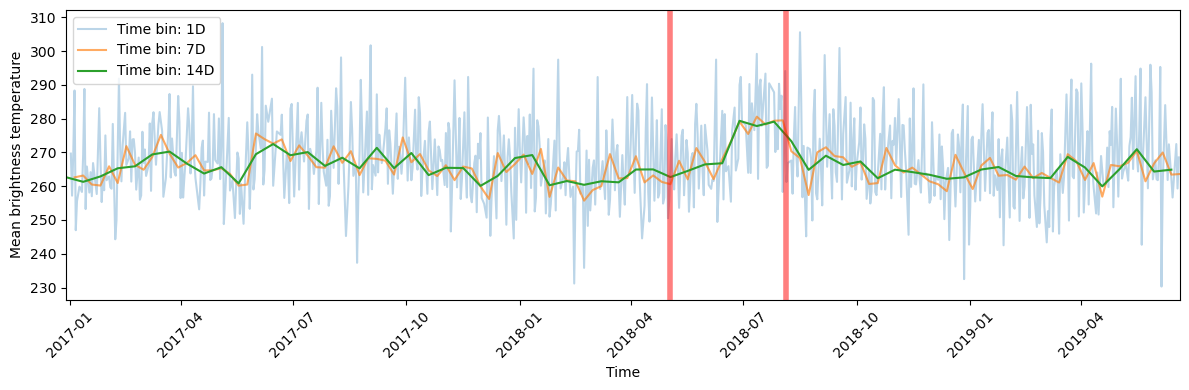

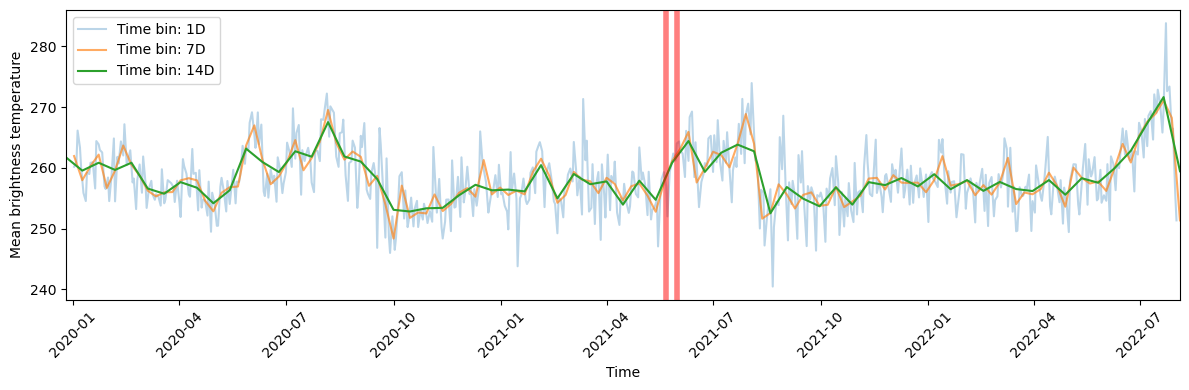

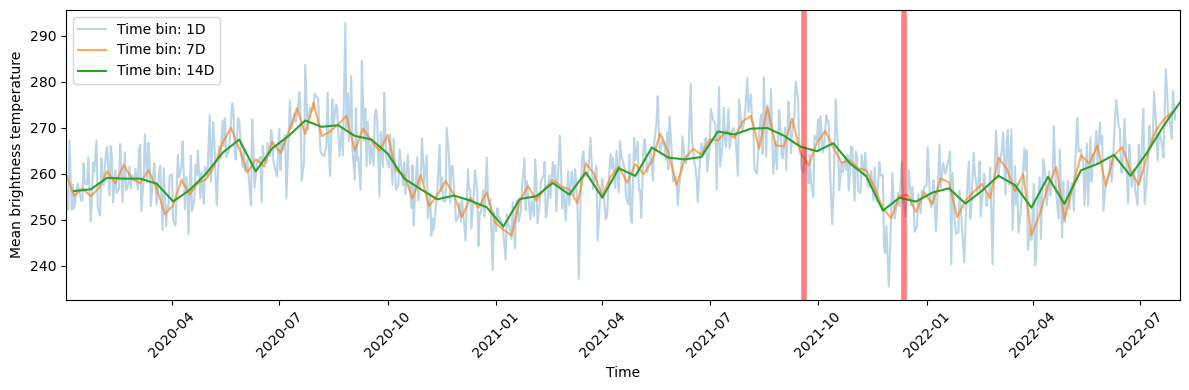

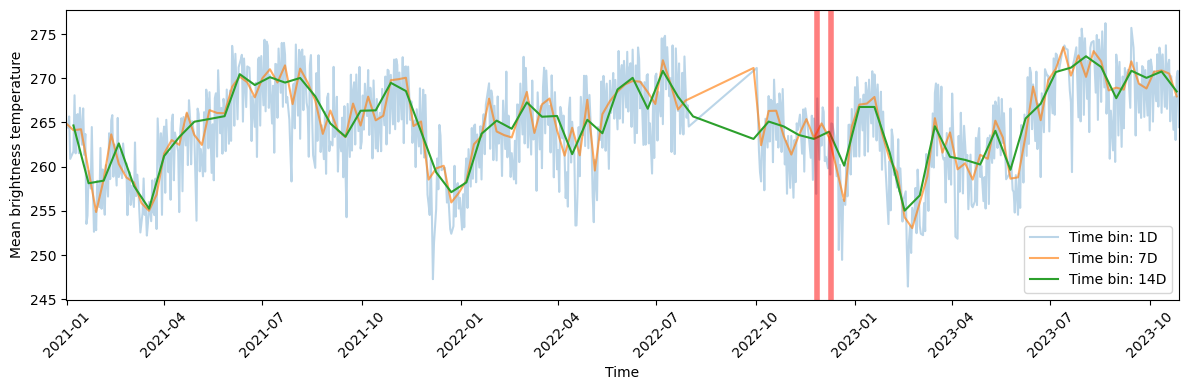

In [8]:
# Kilauea 
dropmask = kilauea_data_frame['tb_time_utc'] < '07-01-2019' # Drop SMAP outage
kilauea_data_frame = kilauea_data_frame[dropmask]
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(111)
multi_bin_process(kilauea_data_frame, ax, time_bins=['1D', '7D', '14D'], center_bins=[0.15])
ylim = ax.get_ylim()
ax.vlines([pd.to_datetime('05/03/2018'), pd.to_datetime('08/05/2018')], *ylim, color='r', alpha=0.5, lw=4)
ax.set_ylim(ylim)
ax.legend()
ax.autoscale(tight=True)
fig.tight_layout()

# Nyiragongo 
dropmask = nyiragongo_data_frame['tb_time_utc'] < '08-01-2022' # Drop SMAP outage
nyiragongo_data_frame = nyiragongo_data_frame[dropmask]
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(111)
multi_bin_process(nyiragongo_data_frame, ax, time_bins=['1D', '7D', '14D'], center_bins=[0.15])
ylim = ax.get_ylim()
ax.vlines([pd.to_datetime('05/22/2021'), pd.to_datetime('05/31/2021')], *ylim, color='r', alpha=0.5, lw=4)
ax.set_ylim(ylim)
ax.legend()
ax.autoscale(tight=True)
fig.tight_layout()

# Cumbre Vieja 
dropmask = cumbrevieja_data_frame['tb_time_utc'] < '08-01-2022' # Drop SMAP outage
cumbrevieja_data_frame = cumbrevieja_data_frame[dropmask]
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(111)
multi_bin_process(cumbrevieja_data_frame, ax, time_bins=['1D', '7D', '14D'], center_bins=[0.15])
ylim = ax.get_ylim()
ax.vlines([pd.to_datetime('09/19/2021'), pd.to_datetime('12/13/2021')], *ylim, color='r', alpha=0.5, lw=4)
ax.set_ylim(ylim)
ax.legend()
ax.autoscale(tight=True)
fig.tight_layout()

# Mauna Loa
dropmask = (maunaloa_data_frame['tb_time_utc'] < '08-01-2022') | (maunaloa_data_frame['tb_time_utc'] > '10-01-2022') # Drop SMAP outage
maunaloa_data_frame = maunaloa_data_frame[dropmask]
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(111)
multi_bin_process(maunaloa_data_frame, ax, time_bins=['1D', '7D', '14D'], center_bins=[0.15])
ylim = ax.get_ylim()
ax.vlines([pd.to_datetime('11/27/2022'), pd.to_datetime('12/10/2022')], *ylim, color='r', alpha=0.5, lw=4)
ax.set_ylim(ylim)
ax.legend()
ax.autoscale(tight=True)
fig.tight_layout()



### Significance of the Kilauea event 

There appears to be a jump in microwave emission over the Kilauea LERZ flow field at around the same time as the eruption in 2018. I'm charting below a marked up version of the same chart from above, and by looking at the maximum temperature and the standard deviation of the brightness temperatures outside of the eruption window, I estimate a ~ 4$\sigma$ significance for the brightness temperature jump 

1D: 3.35 sigma
7D: 3.60 sigma
14D: 4.44 sigma


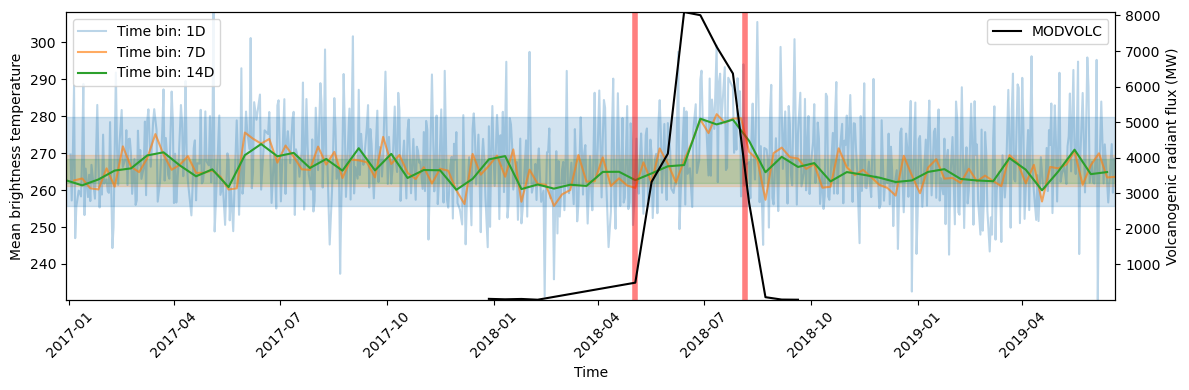

In [ ]:
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(111)
time_bins=['1D', '7D', '14D']
times, mean_tbs = multi_bin_process(kilauea_data_frame, ax, time_bins=time_bins, center_bins=[0.15])
ax.autoscale(tight=True)

ylim = ax.get_ylim()
ax.vlines([pd.to_datetime('05/03/2018'), pd.to_datetime('08/05/2018')], *ylim, color='r', alpha=0.5, lw=4)
ax.set_ylim(ylim)
ax.legend(loc='upper left')

xlim = ax.get_xlim()
for i, mtb in enumerate(mean_tbs):
    ts = times[i]
    mask = (ts < '05-01-2018') | (ts > '09-01-2018')  
    mean = np.mean(mtb[mask])
    std = np.std(mtb[mask])
    mx = np.max(mtb)
    print('{}: {:.2f} sigma'.format(time_bins[i], (mx - mean) / std))
    color = plt.get_cmap('tab10')(i)
    ax.fill_betweenx([mean - std, mean + std], *xlim, color=color, alpha=0.2)
ax.set_xlim(xlim)
fig.tight_layout()

# MODVOLC Input 
file = np.loadtxt('data/modvolc/kiluaea_radiant_flux_MW.txt', skiprows=1)
time = np.asarray(file[:, 0], dtype='datetime64[s]')
power = file[:, -1]
fluxframe = pd.DataFrame(time, columns=['Time'])
fluxframe['Power'] = power
fluxframe['Time Bin'] = fluxframe['Time'].apply(lambda x: x.round('14D'))
fluxframe = fluxframe.groupby(['Time Bin']).mean().reset_index()

tx = ax.twinx()
tx.plot(fluxframe['Time Bin'], fluxframe['Power'], color='k', label='MODVOLC')
tx.set_ylabel('Volcanogenic radiant flux (MW)', color='k')
tx.legend()
tx.autoscale(tight=True)
plt.tight_layout()


### Closing thoughts 

Generally, my analysis concurs with the MacKenzie and Lorenz paper; decimeter-wavelength radiometer instruments currently cannot consistently and reliably detect volcanic signatures on Earth. 

My analysis differs in that I observe an elevated thermal emission signal over the Kilauea LERZ flow with some significance. The main difference between our analysis is the type of product chosen: I used the L1B ungridded product, and MacKenzie and Lorenz used the upsampled 9 km L1C gridded product. I similarly checked the L1C product and saw no obvious signatures.

 A possible advantage of using the L1B product in difficult mixed-scenes is the control that can be exerted over the alignments of the footprints. The significance of the result is sensitive to the range of flow-center distances which are included, and the Backus-Gilbert interpolation used in forming the L1C gridded product could perhaps exhibit similar sensitivity based on the chosen pixel center. While my detection is nominally ~4 $\sigma$, the likely significant systematic effects of different binning strategies lowers my 'practical' confidence in the detection.   

 It's also unclear why the temporal trend in the enhanced brightness temperature should lag the observed infrared radiant flux. There is a significant growth in surface area right around the beginning of July; maybe it's a just matter of surface covered.

<figure class="image">
  <img src="notebooks/smap_volcanism/kilauea_animation.gif" alt="Text" width=50%>
  <figcaption>Animation of the 2018 Kilauea LERZ lava flow path</figcaption>
</figure>

Detecting volcanism on Venus from microwave radiometry will likely be comparably difficult. As MacKenzie and Lorenz and Bondarenko et al. point out, however, perhaps the wider extent of surface volcanic features on Venus or differences in lava cooling rates could increase likelihood of detection. Claims of volcanic activity detection have come from analyses of passive infrared/microwave radiometry and synthetic aperture radar data, although confidence is low in these detections due to the inherent limitations in instrument sensitivity/resolution. Simultaneous observation of surface changes in SAR and elevated infrared and microwave emission would improve confidence, and centimeter-scale deformation detection with the interferometric synthetic aperture radar instrument on the upcoming NASA VERITAS mission would be a smoking gun. 

For now, we'll have to wait, but it won't be long until future Venus missions give us more data than we'll know what to do with! 

*Note: Thanks goes to Indujaa Ganesh from UAF/Georgia Tech (and a member of the EnVision VenSAR science team) for some helpful discussions*